In [1]:
import numpy as np

In [101]:
def calculate_covariance_matrix(x, y=None):
        """Calculates covariance matrix XtX"""
        if y is None:
            y = x
        num_samples = x.shape[0]
        covariance_matrix = (1/(num_samples-1)) * (x - x.mean(axis=0)).T @ (y - y.mean(axis=0))
        return np.array(covariance_matrix, dtype=float)

class GDA(object):
    """Gaussian Discriminant Analysis
    Super class of LDA and QDA
    """
    def __init__(self):
        self.parameters = []
        return
    
    def fit(self, x, y):
        """Fit parameters: prior probabilities, class wise mean and
        variance (common for LDA, class wise for QDA) 
        Assumes samples in each class are Gaussian distributed
        """
        self.classes = np.unique(y)
        #self.parameters = np.empty((1, len(self.classes)))
        self.parameters = []
        # Find mean, covariance matrix for each class
        for i, c in enumerate(self.classes):
            x_class = x[np.where(y==c)]
            """
            params = []
            params["mean"] = x_class.mean(axis=0)
            params["covariance"] = calculate_covariance_matrix(x_class)
            params["prior"] = len(x_class) / len(x)
            """
            params = {  "mean": x_class.mean(axis=0),
                        "covariance": calculate_covariance_matrix(x_class),
                        "prior": len(x_class) / len(x)}
            self.parameters.append(params)
    
    def predict(self, x):
        """Predict class output
        Assign sample to the class with highest posterior probability
        """
        y_pred = []
        for sample in x:
            # Get discriminant function value for each class
            discriminants = self.discriminant_function(sample, self.parameters)
            # Assign to class with highest discriminant function
            y_pred.append(self.classes[np.argmax(discriminants)])
        return y_pred


class LDA(GDA):
    """Linear Discriminant analysis
    Class specific mean and common covariance matrix
    Linear boundary b/w classes
    """
    def _lda_discriminant(self, x, params):
        common_covariance = 0
        for i, params in enumerate(self.parameters):
            # Common covariance across classes (sum all)
            common_covariance += params["covariance"]

        #discriminants = np.zeros((1, len(self.classes)))
        discriminants = []

        for i, params in enumerate(self.parameters):
            # Mean and prior for each class
            mean = np.expand_dims(params["mean"], axis=1)
            prior = params["prior"]
            # Inverse of common covariance matrix
            sigma_inv = np.linalg.pinv(common_covariance)
            # LDA discriminant function
            discriminant = (x.T @ sigma_inv @ mean) - 0.5 * (mean.T @ sigma_inv @ mean) + np.log(prior+1e-7)
            discriminants.append(discriminant)
        return np.array(discriminants)


    def predict(self, x):
        self.discriminant_function = self._lda_discriminant
        return super(LDA, self).predict(x)
    
    def _calculate_scatter_matrices(self, x, y):
        """Calculate scatter matrices
        """
        n_samples, n_features = np.shape(x)
        
        # Within class scatter
        sw = np.empty((n_features, n_features))
        for label in self.classes:
            x_class = x[y == label]
            sw += (len(x_class)-1) * calculate_covariance_matrix(x_class)

        # Across class scatter
        sb = np.empty((n_features, n_features))
        mean_overall = np.mean(x, axis=0)
        for label in self.classes:
            x_class = x[y == label]
            mean_class = np.mean(x_class, axis=0)
            sb += len(x_class) * (mean_class - mean_overall).dot((mean_class - mean_overall).T)
        return sw, sb

    def transform(self, x, y, n_components):
        """Project to lower dimensions (onto LDA decision boundary)
        """
        sw, sb = self._calculate_scatter_matrices(x, y)
        # [TODO: Understand this operation]
        a = np.linalg.inv(sw).dot(sb)

        # Get eigenvectors, eigenvalues of this feature space
        eigenvalues, eigenvectors = np.linalg.eigh(a)

        # Get first n_components eigenvectors in sorted order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx][:n_components]
        eigenvectors = eigenvectors[:, idx][:, :n_components]

        # Transform data by projecting onto eigenvectors
        x_transform = x.dot(eigenvectors)
        return x_transform
    
    def plot_in_2d(self, X, y, title=None):
        """ Plot the dataset X and the corresponding labels y in 2D using the LDA
        transformation."""
        X_transformed = self.transform(X, y, n_components=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        plt.scatter(x1, x2, c=y)
        if title: plt.title(title)
        plt.show()


class QDA(GDA):
    """Quadratic Discriminant analysis
    Class specific mean and class specific covariance matrix
    Quadratic boundary b/w classes
    """
    def _qda_discriminant(self, x, params):
        #discriminants = np.empty((1, len(self.classes)))
        discriminants = []
        for i, params in enumerate(self.parameters):
            # Mean and prior for each class
            mean = np.expand_dims(params["mean"], axis=1)
            prior = params["prior"]
            covariance = params["covariance"]
            # Inverse of common covariance matrix
            sigma_inv = np.linalg.pinv(covariance)
            # LDA discriminant function
            discriminant = -0.5 * (x.T @ sigma_inv @ x)  + (x.T @ sigma_inv @ mean) -\
                0.5 * (mean.T @ sigma_inv @ mean) - 0.5 * (np.log(np.linalg.det(sigma_inv)+1e-7)) +\
                np.log(prior+1e-7)
            discriminants.append(discriminant)
        return np.array(discriminants)


    def predict(self, x):
        self.discriminant_function = self._qda_discriminant
        return super(QDA, self).predict(x)


Accuracy: 0.98


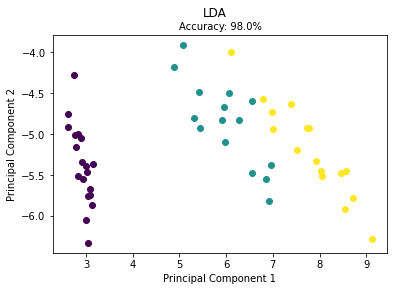

In [102]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

def normalize(X, axis=-1, order=2):
    """Normalise the dataset (unit norm)
        Axis:0 => Each feature(column) is normalised to unit norm
        Axis:1 => Each sample(row) is normalised to unit norm
        X = X / sqrt(sum|X|^2)
    """
    norm = np.atleast_1d(np.linalg.norm(X, ord=order, axis=axis))
    norm[norm == 0] = 1
    return X / np.expand_dims(norm, axis=axis)

data = datasets.load_iris()
X = data.data
y = data.target

# Three -> two classes
#X = X[y != 2]
#y = y[y != 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Fit and predict using LDA
lda = LDA()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)

Plot().plot_in_2d(X_test, y_pred, title="LDA", accuracy=accuracy)


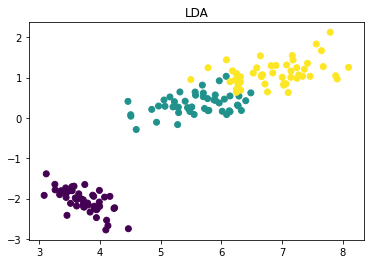

In [103]:
lda.plot_in_2d(X, y, title="LDA")

In [2]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)


bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()